# Loading Real Image Data

So far we've only worked with toy datasets (MNIST, CIFAR-10) conveniently packaged by torchvision, where
every image has the same size and shape. Now let's learn the real deal, and work from a varied collection of .jpg
files.

For this section we'll be working with a version of the Cats vs. Dogs dataset inspired by a classic Kaggle
competition.

A quick note - do not download the dataset from Kaggle! Ours is a cleaned version of the data without any 0by0
files, etc.

The images are similar to ones available from the ImageNet database.

We have organized the files into train and test folders, and further divided the images into CAT and DOG
subfolders. In this way the file path contains the label.

In [77]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

### Examine the data

We'll us Python's built-in os module to walk the directories collecting file names. We'll then use Pillow, an
extension to the Python Imaging Library (PIL), to open image files and extract image sizes. A pandas DataFrame
will provide summary statistics on our data like max/min width & height from which we can choose our model
parameters.

In [78]:
import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')


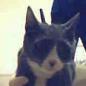

In [79]:
# TEST YOUR VERSION OF PILLOW
with Image.open('data_cnn/CATS_DOGS/test/CAT/10107.jpg') as im:
    display(im)
    

### Create a list of image filenames

In [80]:
path ='data_cnn/CATS_DOGS/'
img_names=[]
for folder, sunfolders, filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)

In [81]:
len(img_names)

24994

### Create a DataFrame of image sizes (width x height)

It's worth noting that Image.open() doesn't read the entire image into memory, so it's a reasonable way to get
image sizes.
Still, this can take awhile.
Images: 24994
Still, this can take awhile.

In [82]:
img_sizes = []
rejected = []

for item in img_names:
    try:
        with Image.open(item) as img:
            img_sizes.append(img.size)
    except:
        rejected.append(item)

In [83]:
print(len(img_sizes))

24994


In [84]:
print(len(rejected))

0


### Convert the list into a dataframe

In [85]:
df = pd.DataFrame(img_sizes)

In [86]:
df.head()

,0,1
0,350,490
1,200,200
2,432,414
3,349,336
4,425,479


In [87]:
df[0].describe()

count    24994.000000
mean       404.493518
std        108.941802
min         42.000000
25%        323.000000
50%        448.000000
75%        500.000000
max        500.000000
Name: 0, dtype: float64

In [88]:
df[1].describe()

count    24994.000000
mean       361.037129
std         96.936811
min         33.000000
25%        302.000000
50%        375.000000
75%        421.000000
max        500.000000
Name: 1, dtype: float64

This tells us the shortest width is 42, the shortest height is 33, the largest width and height are 500, and that
most images have more than 300 pixels per side. This is useful for deciding on an input size. We'll see in the next
section that 224x224 will work well for our purposes (we'll take advantage of some pre-trained models that use
this size!)

### Image Preprocessing

Any network we define requires consistent input data. That is, the incoming image files need to have the same
number of channels (3 for red/green/blue), the same depth per channel (0-255), and the same height and width.
This last requirement can be tricky. How do we transform an 800x450 pixel image into one that is 224x224? In
the theory lectures we covered the following:

*aspect ratio:*  the ratio of width to height (16:9, 1:1, etc.) An 800x450 pixel image has an aspect ration of 16:9.
We can change the aspect ratio of an image by cropping it, by stretching/squeezing it, or by some
combination of the two. In both cases we lose some information contained in the original. Let's say we crop
175 pixels from the left and right sides of our 800x450 image, resulting in one that's 450x450.

*scale:* Once we've attained the proper aspect ratio we may need to scale an image up or down to fit our
input parameters. There are several libraries we can use to scale a 450x450 image down to 224x224 with
minimal loss.

*normalization:* when images are converted to tensors, the [0,255] rgb channels are loaded into range [0,1].
We can then normalize them using the generally accepted values of mean=[0.485, 0.456, 0.406] and std=
[0.229, 0.224, 0.225]. For the curious, these values were obtained by the PyTorch team using a random 10,000
sample of ImageNet images. There's a good discussion of this here, and the original source code can be
found here.

### Transformations

Before defining our Convolutional Network, let's look at a sample image and perform various transformations on
it to see their effect.

In [89]:
dog = Image.open('data_cnn/CATS_DOGS/train/DOG/14.jpg')

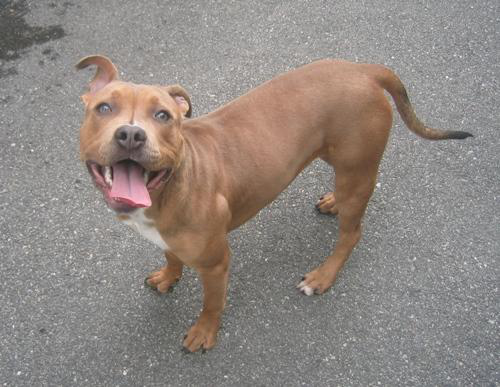

In [90]:
display(dog)

In [91]:
dog.size

(500, 387)

Transformations
Before defining our Convolutional Network, let's look at a sample image and perform various transformations on
it to see their effect.

In [92]:
dog.getpixel((0,0))

(90, 95, 98)

The pixel at position [0,0] (upper left) of the source image has an rgb value of (90,95,98). This corresponds to this
color

Great! Now let's look at some specific transformations.

transforms.ToTensor()
transforms.ToTensor()


In [74]:
#transforms.ToTensor()

<class 'torch.Tensor'>
torch.Size([3, 387, 500])


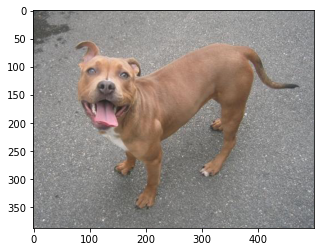

In [93]:
transform = transforms.Compose([transforms.ToTensor()])
im= transform(dog)
print(type(im))
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1,2,0)));

Converts a PIL Image or numpy.ndarray (HxWxC) in the range [0, 255] to a torch.FloatTensor of shape
(CxHxW) in the range [0.0, 1.0]

This is the same image converted to a tensor and displayed using matplotlib. Note that the torch dimensions
follow [channel, height, width]

PyTorch automatically loads the [0,255] pixel channels to [0,1]:

In [94]:
im

tensor([[[0.3529, 0.3451, 0.3373,  ..., 0.5686, 0.5333, 0.5216],
         [0.3255, 0.3412, 0.3333,  ..., 0.5765, 0.5451, 0.5294],
         [0.2863, 0.3216, 0.3373,  ..., 0.5529, 0.5255, 0.4980],
         ...,
         [0.5765, 0.5451, 0.4824,  ..., 0.5686, 0.5059, 0.5216],
         [0.6157, 0.5922, 0.4941,  ..., 0.5294, 0.5176, 0.5176],
         [0.5922, 0.5843, 0.5020,  ..., 0.5882, 0.6314, 0.6039]],

        [[0.3725, 0.3647, 0.3569,  ..., 0.5725, 0.5373, 0.5255],
         [0.3451, 0.3608, 0.3529,  ..., 0.5804, 0.5490, 0.5333],
         [0.3059, 0.3412, 0.3569,  ..., 0.5569, 0.5294, 0.5020],
         ...,
         [0.5608, 0.5294, 0.4745,  ..., 0.5765, 0.5137, 0.5294],
         [0.6000, 0.5765, 0.4863,  ..., 0.5373, 0.5255, 0.5255],
         [0.5765, 0.5686, 0.4941,  ..., 0.5961, 0.6392, 0.6118]],

        [[0.3843, 0.3765, 0.3686,  ..., 0.5882, 0.5529, 0.5412],
         [0.3569, 0.3725, 0.3647,  ..., 0.5961, 0.5647, 0.5490],
         [0.3176, 0.3529, 0.3686,  ..., 0.5725, 0.5451, 0.

In [95]:
im[:,0,0]

tensor([0.3529, 0.3725, 0.3843])

In [96]:
np.array((90,95,98))/255 # 255 is the max value

array([0.35294118, 0.37254902, 0.38431373])

*Note:* For the normalization, pytorch divide all the pixel values by the max value(255)

### Resizing the dod Image 14

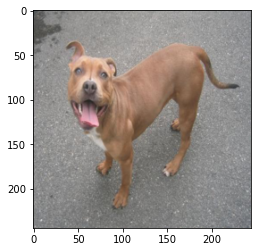

In [98]:
transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.ToTensor()])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### Center Cropping the image

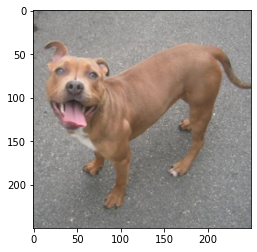

In [100]:
transform = transforms.Compose([transforms.Resize(250),
                                transforms.CenterCrop(250),
                                transforms.ToTensor()])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### Rondom horizontally filpping the image

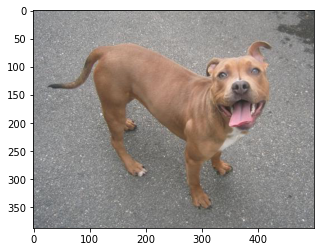

In [101]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1),# probability of 100%
                                transforms.ToTensor()])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### Randomly rotating the image

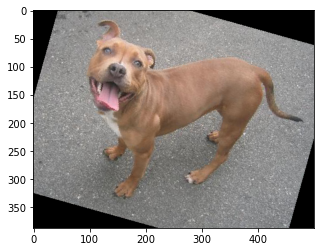

In [102]:
transform = transforms.Compose([transforms.RandomRotation(30),
                                transforms.ToTensor()])
im = transform(dog)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

### Normalization

Once the image has been loaded into a tensor, we can perform normalization on it. This serves to make
convergence happen quicker during training. The values are somewhat arbitrary - you can use a mean of 0.5 and
a standard deviation of 0.5 to convert a range of [0,1] to [-1,1], for example.
However, research has shown that mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] work well in practice.

transforms.Normalize(mean, std)

Given mean: (M1,...,Mn) and std: (S1,..,Sn) for n channels, this transform will normalize each channel of the input
tensor

torch.Size([3, 387, 500])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


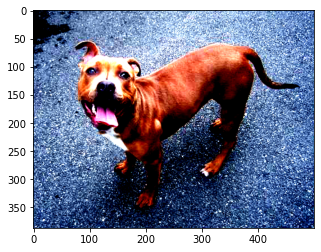

In [103]:
transform = transforms.Compose([transforms.ToTensor(),
           transforms.Normalize([0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])
])

im = transform(dog)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

Recall that before normalization, the upper-leftmost tensor had pixel values of [0.3529, 0.3725, 0.3843].
With normalization we subtract the channel mean from the input channel, then divide by the channel std.

When displayed, matplotlib clipped this particular pixel up to [0,0,0] so it appears black on the screen. However,
the appearance isn't important; the goal of normalization is improved mathematical performance.

### Optional: De-normalize the images

To see the image back in its true colors, we can apply an inverse-transform to the tensor being displayed.

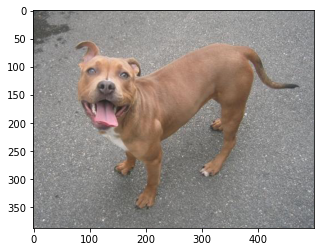

In [104]:
inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));